In [55]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [48]:
datasets_dir = os.path.join(os.getcwd(), 'datasets')
file_name = 'AABA_2006-01-01_to_2018-01-01.csv'
file_path = os.path.join(datasets_dir, file_name)
df = pd.read_csv(file_path)


In [49]:
diff_close_series = df['Close'].diff().dropna()

# Create lagged features from differences
lagged_data = pd.concat(
    [diff_close_series.shift(i) for i in range(5, -1, -1)],
    axis=1
).dropna()
lagged_data.columns = [f'lag_{i}' for i in range(5, -1, -1)]

# Split into 50% train and 50% test
split_idx = int(len(lagged_data) * 0.6)
train_data = lagged_data.iloc[:split_idx]
test_data = lagged_data.iloc[split_idx:]


In [50]:
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [51]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [52]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [53]:
model = Sequential()
model.add(Input(shape=(X_train_reshaped.shape[1], 1)))  # Explicit input layer
model.add(LSTM(50, return_sequences=False))
model.add(LeakyReLU(negative_slope=0.01))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [56]:
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=8, verbose=1)


Epoch 1/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0238
Epoch 2/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8648
Epoch 3/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0878
Epoch 4/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7343
Epoch 5/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7266
Epoch 6/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6996
Epoch 7/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8596
Epoch 8/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7069
Epoch 9/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5713
Epoch 10/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8521
Epoch 11/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6273
Epoch 12/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6471
Epoch 13/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8136
Epoch 14/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7237
Epoch 15/200
226/226 ━━━━━━━━━━━━━━━━━━━━ 1

In [57]:
y_train_pred_scaled = model.predict(X_train_reshaped)
y_test_pred_scaled = model.predict(X_test_reshaped)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [58]:
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

In [59]:
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)

In [60]:
print(f"Test MSE: {mse_test:.6f}")
print(f"Test RMSE: {rmse_test:.6f}")
print(f"Test MAE: {mae_test:.6f}")


Test MSE: 1.030511
Test RMSE: 1.015141
Test MAE: 0.750193


arima

In [61]:
arima_model = ARIMA(y_train, order=(5, 1, 0))  # Example order (p, d, q)
arima_fit = arima_model.fit()
y_train_pred_arima = arima_fit.predict(start=0, end=len(y_train) - 1, typ='levels')
y_test_pred_arima = arima_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')

/home/ryu/code/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [63]:
mse_train_arima = mean_squared_error(y_train, y_train_pred_arima)
r2_train_arima = r2_score(y_train, y_train_pred_arima)
mae_train_arima = mean_absolute_error(y_train, y_train_pred_arima)

mse_test_arima = mean_squared_error(y_test, y_test_pred_arima)
r2_test_arima = r2_score(y_test, y_test_pred_arima)
mae_test_arima = mean_absolute_error(y_test, y_test_pred_arima)


In [64]:
print("\nARIMA Results:")
print(f"Train MSE: {mse_train_arima:.6f}, Train R2: {r2_train_arima:.6f}, Train MAE: {mae_train_arima:.6f}")
print(f"Test MSE: {mse_test_arima:.6f}, Test R2: {r2_test_arima:.6f}, Test MAE: {mae_test_arima:.6f}")

# SARIMA Model


ARIMA Results:
Train MSE: 0.380939, Train R2: -0.172861, Train MAE: 0.380022
Test MSE: 0.524783, Test R2: -0.042391, Test MAE: 0.532252


sarima

In [65]:
sarima_model = SARIMAX(y_train, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))  # Example order
sarima_fit = sarima_model.fit(disp=False)
y_train_pred_sarima = sarima_fit.predict(start=0, end=len(y_train) - 1)
y_test_pred_sarima = sarima_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)


In [67]:
mse_train_sarima = mean_squared_error(y_train, y_train_pred_sarima)
r2_train_sarima = r2_score(y_train, y_train_pred_sarima)
mae_train_sarima = mean_absolute_error(y_train, y_train_pred_sarima)

mse_test_sarima = mean_squared_error(y_test, y_test_pred_sarima)
r2_test_sarima = r2_score(y_test, y_test_pred_sarima)
mae_test_sarima = mean_absolute_error(y_test, y_test_pred_sarima)

In [68]:
print("\nSARIMA Results:")
print(f"Train MSE: {mse_train_sarima:.6f}, Train R2: {r2_train_sarima:.6f}, Train MAE: {mae_train_sarima:.6f}")
print(f"Test MSE: {mse_test_sarima:.6f}, Test R2: {r2_test_sarima:.6f}, Test MAE: {mae_test_sarima:.6f}")


SARIMA Results:
Train MSE: 0.432122, Train R2: -0.330446, Train MAE: 0.403165
Test MSE: 0.648975, Test R2: -0.289078, Test MAE: 0.618019


Random Forest

In [84]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=39)
rf_model.fit(X_train, y_train)
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)


In [85]:
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)

mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)

In [86]:
print("\nRandom Forest Results:")
print(f"Train MSE: {mse_train_rf:.6f}, Train R2: {r2_train_rf:.6f}, Train MAE: {mae_train_rf:.6f}")
print(f"Test MSE: {mse_test_rf:.6f}, Test R2: {r2_test_rf:.6f}, Test MAE: {mae_test_rf:.6f}")



Random Forest Results:
Train MSE: 0.049310, Train R2: 0.848180, Train MAE: 0.134354
Test MSE: 0.562682, Test R2: -0.117670, Test MAE: 0.557398


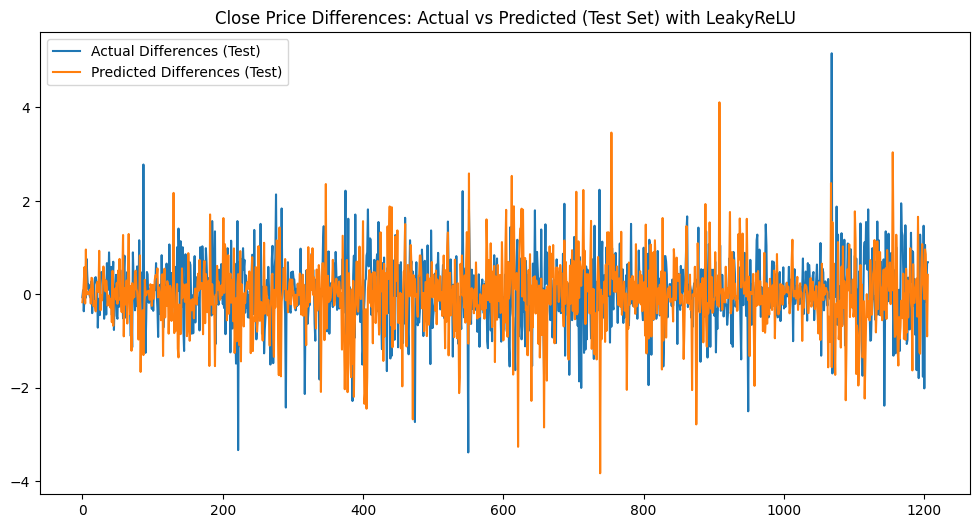

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Differences (Test)')
plt.plot(y_test_pred, label='Predicted Differences (Test)')
plt.title("Close Price Differences: Actual vs Predicted (Test Set) with LeakyReLU")
plt.legend()
plt.show()